# Optimization Methods for Data Science

##### Authors: Mojtaba Amini , Kamile Dementaviciute, Saeed Soufeh

##### HW1
##### Deadline: 04/11/2022

In the first part, the random data has been generated.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from time import process_time
import pandas as pd


Original size of X= 300	Unlabeled size = 294	labeled size = 6
Original size of y= 300	Unlabeled size = 294	labeled size = 6


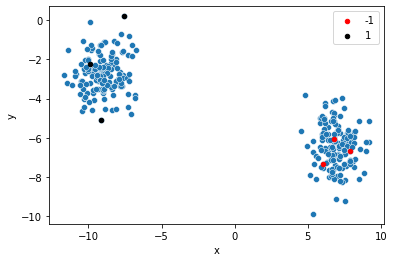

In [2]:
# generate 2d classification dataset
np.random.seed(15)
X, y = make_blobs(n_samples=300, centers=2, n_features=2)
x_Unlabeled ,x_labeled_bar,y1,y_label = train_test_split(X,y,test_size=0.02)

print(f"Original size of X= {X.shape[0]}\tUnlabeled size = {x_Unlabeled.shape[0]}\tlabeled size = {x_labeled_bar.shape[0]}")
print(f"Original size of y= {y.shape[0]}\tUnlabeled size = {y1.shape[0]}\tlabeled size = {y_label.shape[0]}")

y_label=y_label*2-1
df = DataFrame(dict(x=x_labeled_bar[:,0], y=x_labeled_bar[:,1], label=y_label))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
sns.scatterplot(ax=ax,x=X[:,0],y=X[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()



### <mark><b>Similarity Measure function</b></mark>

<ol>
  <li><b>Euclidean Distance</b></li>
  At first, for similarity, the similarity measure function has been defined as below:
  $$ d(x,y) = {e^{\sum_{i=1}^k (x_i-y_i)^2 }}$$

  So the similarity matrix is defined as below:

  $$\omega_{ij}={e^{(x_{1i}-x_{1j})^2+(x_{2i}-x_{2j})^2}}$$

  ${x_1}$ refer to the first dimension and ${x_2}$ is the second dimension in 2D.

  ${i ,j}$ are two indexes for labeled and unlabeled data. 

  Therefore the matrix is as below:

  $$
\omega_{ij}= \begin{bmatrix}
{e^{(x_{11}-x_{11})^2+(x_{21}-x_{21})^2}} & {e^{(x_{11}-x_{12})^2+(x_{21}-x_{22})^2}} & \cdots \\
{e^{(x_{12}-x_{11})^2+(x_{22}-x_{21})^2}} & \ddots & \cdots \\
\vdots & \cdots & \cdots \\
\end{bmatrix}
$$
</ol>

<b>Defining Similarity functions:</b>

In [3]:
def Gaussian_distance(x,y):
  return np.exp(-np.linalg.norm(x-y)**2)

<b> Initializing matrixes</b>

In [4]:
def initialize_parameters(x_Unlabeled):
  np.random.seed(4)
# initialize the parameters with non-zeros numbers between(0,1)
  y_unlabel=np.random.rand(len(x_Unlabeled))*0.01
  return y_unlabel

<b>Defining the similarity matrix</b>

In [5]:
def similarity(x_Unlabeled,x_labeled_bar,type):
  wij=np.zeros((len(x_labeled_bar),len(x_Unlabeled)))
  wij_bar=np.zeros((len(x_Unlabeled),len(x_Unlabeled)))

  if type=="Gaussian" :
    for j in range(len(x_Unlabeled)):
      for i in range(len(x_labeled_bar)):
        wij[i,j] = Gaussian_distance(x_labeled_bar[i,:],x_Unlabeled[j])
      for i in range(len(x_Unlabeled)):
        wij_bar[i,j] = Gaussian_distance(x_Unlabeled[i],x_Unlabeled[j])
  return wij,wij_bar

### <mark><b>Cost function and it's derivative</b></mark>


 Cost function:
  $$ \min_{y\in{R^u}} \sum_{i=1}^l\sum_{j=1}^u \omega_{ij}(y^{j}-\bar{y}^{i})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})^2 $$

Gradient with respect to $y^{j}$:
$$\nabla_{y^{j}} f(y)=2\sum_{i=1}^l \omega_{ij}(y^{j}-\bar{y}^{i})+2 \sum_{i=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})$$

$u$ : unlabeled data

$l$ : labeled data

$y$ : predicted label ( parameters)

$\bar{y}$ : determined label

$\omega_{ij}$ : similarity measure matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity measure matrix between unlabeled data


In [19]:
def cost_function(wij,wij_bar,y_unlabel,y_label):
  cost=0.0
  term1=0.0
  term2=0.0

  y_label_matrix=np.tile(y_label,(y_unlabel.shape[0],1))
  y_unlabel_array=np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_reshaped=wij.T
  sub1=np.power(y_label_matrix-y_unlabel_array,2)
  mat1= wij_reshaped*sub1
  term1=np.sum(mat1)

  y_unlabel_matrix=np.tile(y_unlabel,(y_unlabel.shape[0],1))
  y_unlabel_array=np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_bar_reshaped=wij_bar.T
  sub2=np.power(y_unlabel_matrix-y_unlabel_array,2)
  mat2= wij_bar_reshaped*sub2
  term2=np.sum(mat2)

  cost = term1 + 0.5*term2
  return cost

In [7]:
def dev_function(wij,wij_bar,y_unlabel,y_label,method,index=1,size=0):
  dev=0.0

  if method=="GD":
    size=y_unlabel.shape[0]
    dev=np.zeros(size)
    for j in range(size):
      term1=0.0
      term2=0.0
      for i in range(len(y_label)):
        term1 = term1+wij[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_label[i])
      for i in range(len(y_unlabel)):
        term2 = term2+wij_bar[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_unlabel[i])
      dev[j] = 2*(term1 + term2)
  elif method=="BCGD":
    dev=np.zeros(size)
    for j in range(size):
      term1=0.0
      term2=0.0
      for i in range(len(y_label)):
        term1 = term1+wij[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_label[i])
      for i in range(len(y_unlabel)):
        term2 = term2+wij_bar[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_unlabel[i])
      dev[j] = 2*(term1 + term2)

  return dev  

### <mark><b>Gradient Decent</b></mark>


BCGD with Cyclic Rule
CPU time: 54.723734173000004


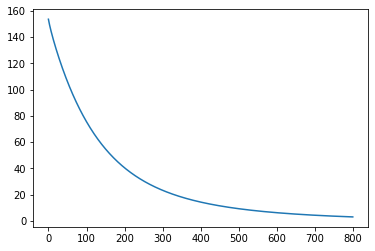

In [10]:
#Gradient Decend
alpha=0.003
num_iteration=800
time_tracking = np.zeros(num_iteration)
t1_start = process_time() 
y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func=np.zeros(num_iteration)

for i in range(num_iteration):
  derivative=dev_function(wij,wij_bar,y_unlabel,y_label,method="GD")
  y_unlabel=y_unlabel-alpha*derivative
  cost_func[i]=cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i] = process_time() - t1_start
t1_stop = process_time()
print("BCGD with Cyclic Rule")
print("CPU time:", t1_stop - t1_start)
sns.lineplot(x= range(num_iteration),y=cost_func)

Visualizing the result to see that the assignment is correct or not!

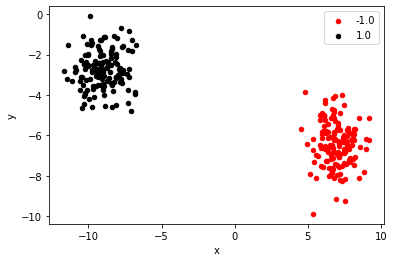

In [13]:
y_unlabel2=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel2))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Randomized Block Coordinate Decent</b></mark>

Since we want to be faster, we just want to calculate a part of derivative. Therefore, we change the derivative function for randomized and cyclic. methods.

BCGD with Cyclic Rule
CPU time: 201.77360710499997


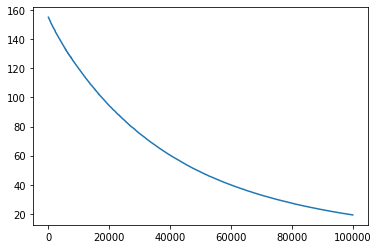

In [17]:
#Gradient Decend
alpha=0.003
num_iteration=100000
time_tracking = np.zeros(num_iteration)
t1_start = process_time() 
y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func=np.zeros(num_iteration)
Block_size=1
Num_Block=int(y_unlabel.shape[0]/Block_size)
for i in range(num_iteration):
  Block_index=np.random.randint(1,Num_Block+1)
  derivative=dev_function(wij,wij_bar,y_unlabel,y_label,method="BCGD",index=Block_index,size=Block_size)
  y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)]=y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
  -alpha*derivative
  cost_func[i]=cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i] = process_time() - t1_start
t1_stop = process_time()
print("BCGD with Cyclic Rule")
print("CPU time:", t1_stop - t1_start)
sns.lineplot(x= range(num_iteration),y=cost_func)

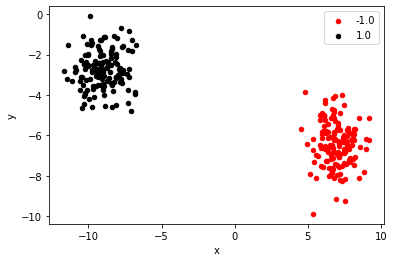

In [18]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Cyclic Block Coordinate Decent</b></mark>

BCGD with Cyclic Rule
CPU time: 59.41320035999999


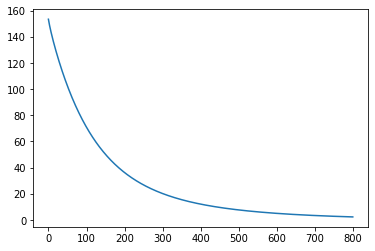

In [11]:
#Gradient Decend
alpha=0.003
num_iteration=800
time_tracking = np.zeros(num_iteration)
t1_start = process_time() 
y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func=np.zeros(num_iteration)
Block_size=1
Num_Block=int(y_unlabel.shape[0]/Block_size)
for i in range(num_iteration):
  for Block_index in range(1,Num_Block+1):
    derivative=dev_function(wij,wij_bar,y_unlabel,y_label,method="BCGD",index=Block_index,size=Block_size)
    y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)]=y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
    -alpha*derivative
  cost_func[i]=cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i] = process_time() - t1_start
t1_stop = process_time()
print("BCGD with Cyclic Rule")
print("CPU time:", t1_stop - t1_start)
sns.lineplot(x= range(num_iteration),y=cost_func)

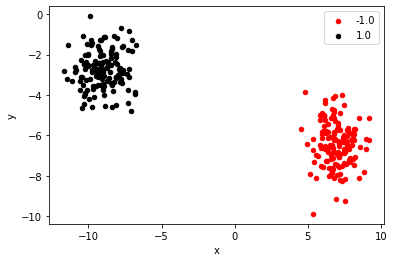

In [12]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
no_it = 400
I_n = np.identity(len(x_Unlabeled))
cost_func = np.zeros(num_iteration)
time_tracking = np.zeros(num_iteration)

t1_start = process_time() 

In [ ]:
for it in range(no_it):

  for block in I_n:
    grad = dev_function(wij,wij_bar,y_unlabel,y_label,method="GD")
    y_unlabel = y_unlabel - alpha * block * grad
  
  dir = - grad
  gnr = np.dot(grad, dir) #product of the gradient with the direction
  print("gnr: ", gnr)
  # print("n: ", len(x_Unlabeled))
  print(abs(len(x_Unlabeled) * gnr))

  cost_func[it] = cost_function(wij,wij_bar,y_unlabel,y_label) 
  time_tracking[it] = process_time() - t1_start

  # stopping criterion based on the product of the gradient with the direction
  if abs(len(x_Unlabeled) * gnr) <= 10: # set a good eps value
    break 

t1_stop = process_time()

print("BCGD with Cyclic Rule")
print("CPU time:", t1_stop - t1_start)


sns.lineplot(x= range(num_iteration),y=cost_func)

gnr:  -408.4501869554168
120084.35496489254
gnr:  -376.5125287524561
110694.6834532221
gnr:  -359.19136312751033
105602.26075948804
gnr:  -347.328692006413
102114.63544988542
gnr:  -337.8192951327408
99318.8727690258
gnr:  -329.5240377771344
96880.06710647752
gnr:  -321.978128123582
94661.5696683331
gnr:  -314.9647929012844
92599.64911297761
gnr:  -308.3669070063367
90659.870659863
gnr:  -302.11191675522434
88820.90352603595
gnr:  -296.14975414557824
87068.0277188
gnr:  -290.4431483257289
85390.2856077643
gnr:  -284.9629305039003
83779.10156814668
gnr:  -279.6855123770674
82227.54063885783
gnr:  -274.5913935895218
80729.86971531941
gnr:  -269.66420073325907
79281.27501557817


KeyboardInterrupt: ignored

In [ ]:
'''Line Search'''


#         %linesearch
        
#         %set z=x
#         z=x;
#         switch arls
#             case 1
                
#                 %Armijo search
#                 alpha=1.0;
#                 ref = gamma*gnr;
                
#                 while(1)
#                     z(ind)=x(ind)+alpha*d;
                    
#                     %Smart computation of the o.f. at the trial point
#                     fz = fx+alpha*d*gi+0.5*(alpha*d)^2*Qii;
                    
#                     if (fz<=fx+alpha*ref)
#                         z(ind)=x(ind)+alpha*d;
#                         break;
#                     else
#                         alpha=alpha*0.1;
#                     end
                    
#                     if (alpha <= 1e-20)
#                         z=x;
#                         fz=fx;
#                         flagls=1;
#                         it = it-1;
#                         break;
#                     end
                    
#                 end
                
#             otherwise
#                 %exact alpha
#                 alpha=1/Qii;
#                 z(ind)=x(ind)+alpha*d;
#                 fz = fx+alpha*d*gi+0.5*(alpha*d)^2*Qii;   
#         end


# arls: line search (1 Armijo 2 exact)
# maxit: maximum number of iterations
# eps: tolerance
# fstop: target o.f. value
# stopcr: stopping condition